# Lesson 4: JIT-compiled Python

Although array-oriented programming lets you use precompiled (fast) numerical calculations in a dynamic interpreter like Python (or MATLAB, or APL, ...), it has three shortcomings:

  1. It may be unfamiliar. If you learn programming with `for` loops and `if` branches, it can be hard to rethink problems in terms of mappers, reducers, slices, `axis`, and such.

  2. Allocating new arrays for each intermediate step is slower than a single pass and uses more memory (for multiple reasons).

  3. There are types of problems that don't fit the array-oriented paradigm well, such as algorithms that must "iterate until converged."

Just-In-Time (JIT) compilation is another way to get fast numerical calculations in a dynamic interpreter.

<br><br><br>

I advocate for both techniques because

  * array-oriented programming fits the cadence of data analysis;
  * JIT-compilation provides extra speed, better memory use, or is just an easier way to solve problems when necessary.

Demonstration of memory use:

<br>

In [1]:
import awkward as ak

<br>

In [2]:
array = ak.Array([range(20), []])

<br>

In [3]:
array.nbytes

184

In [4]:
ak.combinations(array, 2).nbytes

3064

In [5]:
ak.combinations(array, 3).nbytes

27384

In [6]:
ak.combinations(array, 4).nbytes

155064

In [7]:
ak.combinations(array, 5).nbytes

620184

<br>

Some physics analyses have to combine a large number of particles to form a candidate.

Demonstration of the "iterate until converged" problem: suppose we want to draw the Mandelbroit set.

<br>

<center>
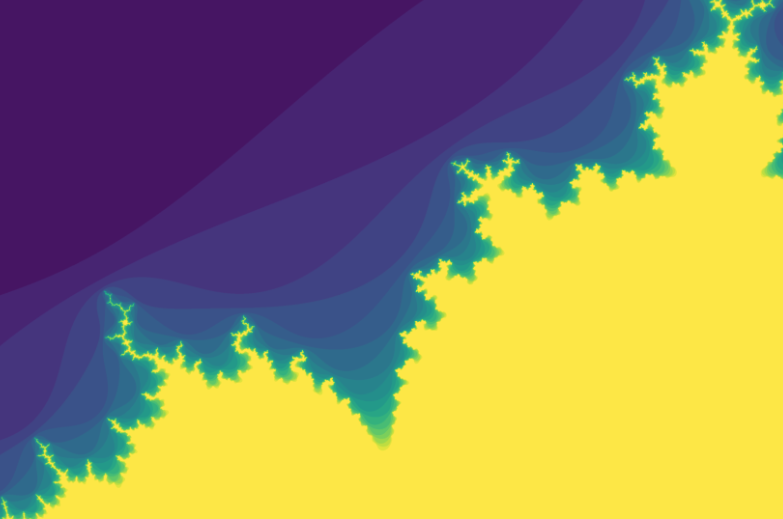
</center>

<br>

This picture a 2-dimensional grid of complex numbers $c$ (horizontal axis is the real part, vertical axis is the imaginary part of each point $c$), in which we compute

$$z_{i + 1} = \left|{z_i}\right|^2 + c \mbox{\hspace{0.5 cm}with\hspace{0.5 cm}} z_0 = c$$

repeatedly until $z_i$ seems to diverge ($|z_i| > 2$). The number of iterations required is the color of the pixel.

Implementation using Python imperative programming:

In [8]:
import matplotlib.pyplot as plt
import numpy as np

<br>

In [9]:
def run_python(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(20):                 # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if z.real**2 + z.imag**2 > 4:   # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

<br>

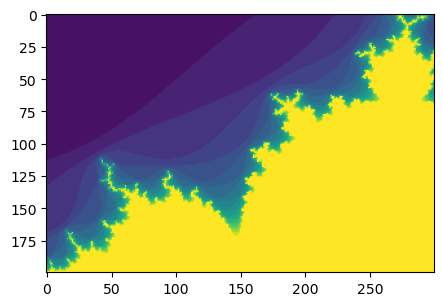

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(run_python(200, 300));

A NumPy solution to this problem would have to remove the `for` loops over pixels,

```python
for h in range(height):
    for w in range(width):
```

with a function that performs the loop in precompiled code.

<br>

The problem is that each pixel `(w, h)` does a different amount of work:

```python
        z = c[h, w]
        for i in range(20):
            z = z**2 + c[h, w]
            if abs(z) > 2:
                fractal[h, w] = i
                break
```

<br>

The array-oriented solution needs to keep track of which pixels have already diverged (`break`) and which still need more computations.

It needs to act on all pixels equally and then fix the diverged set.

In [11]:
def run_numpy(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int32)
    z = c
    for i in range(20):
        z = z**2 + c                                 # applying z → z² + c
        diverged = z.real**2 + z.imag**2 > 4         # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == 20)   # some are already done
        fractal[diverging_now] = i                   # just set the new ones
        z[diverged] = 2                              # clamp diverged at 2
    return fractal

<br>

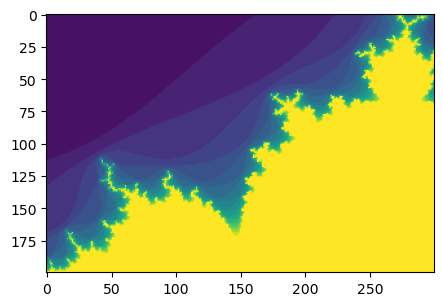

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(run_numpy(200, 300));

The NumPy version is faster because even with this handicap, NumPy array operations are faster than Python `for` loops.

<br>

In [ ]:
%%timeit -r1   # -r1: only run once (it takes too long)

run_python(1000, 1500)

<br>

In [ ]:
%%timeit

run_numpy(1000, 1500)

Ideally, we'd like to take the part of the algorithm that needs to run fast, compile only that, and run it from Python.

<br><br><br>

Even better if we don't need to rewrite the code from Python to C/C++/other fast language.

<br><br><br>

[Numba](https://numba.pydata.org/) does that: it compiles a _subset_ of Python in a way that's easy to streamline into other Python code.

This is the same code as `run_python` except: (1) it is broken into two functions, (2) the second function is decorated with `@nb.jit` to JIT-compile it.

In [ ]:
import numba as nb

In [ ]:
def run_numba(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]  # couldn't compile this first line
    return numba_inner_loop(height, width, x, y)

@nb.jit
def numba_inner_loop(height, width, x, y):            # compiled inner loop as a function
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int32)
    for h in range(height):                           # Python for loops over the pixels
        for w in range(width):
            z = c[h, w]
            for i in range(20):                       # the "iterate until converged" loop
                z = z**2 + c[h, w]
                if z.real**2 + z.imag**2 > 4:
                    fractal[h, w] = i
                    break                             # pixel is done: break out of the loop
    return fractal

<br>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(run_numpy(200, 300));

The Numba version looks like the Python version, but is even faster than the NumPy version.

<br>

In [ ]:
%%timeit -r1   # -r1: only run once (it takes too long)

run_python(1000, 1500)

<br>

In [ ]:
%%timeit

run_numpy(1000, 1500)

<br>

In [ ]:
%%timeit

run_numba(1000, 1500)

But sometimes we have algorithms that are best described in array-oriented form.

<br><br><br>

Ideally, we'd like to take _those_ algorithms, mark them for compilation, and let that compiler take advantage of the implicit loops in its optimizations.

<br><br><br>

[JAX](https://jax.readthedocs.io/) does that: it compiles operations on special JAX arrays (no `for` or `if` allowed).

Below is an adaptation of `run_numpy` for JAX.

In [ ]:
import jax

<br>

In [ ]:
def run_jax(height, width):
    y, x = jax.numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = jax.numpy.full(c.shape, 20, dtype=np.int32)
    return np.asarray(jax_inner_loop(c, fractal).block_until_ready())

@jax.jit
def jax_inner_loop(c, fractal):
    z = c
    for i in range(20):
        z = z**2 + c
        diverged = jax.numpy.absolute(z) > 2
        diverging_now = diverged & (fractal == 20)
        fractal = jax.numpy.where(diverging_now, i, fractal)    # masked assignment → np.where
    return fractal

<br>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(run_jax(200, 300));

JAX runs even faster (by using the GPU or all CPU cores without even asking).

<br>

In [ ]:
%%timeit

run_numpy(1000, 1500)

<br>

In [ ]:
%%timeit

run_numba(1000, 1500)

<br>

In [ ]:
%%timeit

run_jax(1000, 1500)

| | imperative | array-oriented |
|--:|:--:|:--:|
| **no JIT** | Python | NumPy |
| **JIT-compiled** | Numba | JAX |

<br><br><br>

Generally,

$$\mbox{Python\hspace{0.5 cm}} \ll \mbox{\hspace{0.5 cm}NumPy\hspace{0.5 cm}} \ll \mbox{\hspace{0.5 cm}any JIT compilation}$$

but Numba vs JAX depends on details.

Thorough study, using this Mandelbrot example: as a [GitHub Gist](https://gist.github.com/jpivarski/da343abd8024834ee8c5aaba691aafc7), on [Google Colab](https://drive.google.com/file/d/1J0l5e0NZm5kEm5BEUDG4neN5EN0VVCnt/view?usp=sharing).

<center>
<img src="img/plot-mandelbrot-on-all-accelerators.svg" width="100%">
</center>

The long history of Python-compiler interfaces:

<center>
<img src="img/history-of-bindings-2.svg" width="80%">
</center>

## Moving on to the next sessions

<br><br>

Next, you'll be learning a lot about C++ programming, GPU programming, machine learning, and JAX.

<br><br>

Everything that follows is either accessed through Python or can be.

### C++

<br>

In [ ]:
%%writefile run_pybind11.cpp
#include <complex>
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

namespace py = pybind11;

void run(int height, int width, py::array_t<std::complex<double>> np_c,
         py::array_t<int> np_fractal) {
    std::complex<double>* c = static_cast<std::complex<double>*>(np_c.request().ptr);
    int* fractal = static_cast<int*>(np_fractal.request().ptr);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            std::complex<double> ci = c[h + height*w];
            std::complex<double> z = ci;
            for (int i = 0;  i < 20;  i++) {
                z = z * z + ci;
                if (z.real()*z.real() + z.imag()*z.imag() > 4) {
                    fractal[h + height*w] = i;
                    break;
}}}}}

PYBIND11_MODULE(run_pybind11, m) {
    m.def("run", &run);
}

In [ ]:
%%bash

export PYTHON_CONFIG=`which python-config python3-config | head -n1`

c++ -Wall -shared -std=c++11 -fPIC -O3 `python -m pybind11 --includes` run_pybind11.cpp \
    -o run_pybind11`$PYTHON_CONFIG --extension-suffix`

<br>

In [ ]:
import run_pybind11

def run_c_plus_plus(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int32)
    run_pybind11.run(height, width, c, fractal)
    return fractal

<br>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(run_c_plus_plus(2000, 3000));

### GPUs

<br>

In [ ]:
import cupy as cp

cupy_custom_kernel = cp.RawKernel("""
#include <cupy/complex.cuh>

extern "C" __global__
void cupy_custom_kernel(int height, int width, int* fractal) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    complex<float> j(0.0, 1.0);
    complex<float> z, c;
    z = c = complex<float>(-1.5 + y*1.0/(height + 1)) - j
          + complex<float>(x*1.5)*j/complex<float>(width + 1);

    fractal[y + x*width] = 20;
    for (int i = 0;  i < 20;  i++) {
        z = z * z + c;
        if (z.real()*z.real() + z.imag()*z.imag() > 4) {
            fractal[y + x*width] = i;
            break;
        }
    }
}
""", "cupy_custom_kernel")

In [ ]:
def run_cupy(height, width):
    fractal = cp.empty((height, width), dtype=np.int32)
    griddim = (int(np.ceil(height / 32)), int(np.ceil(width / 32)))
    blockdim = (32, 32)
    cupy_custom_kernel(griddim, blockdim, (height, width, fractal))
    return fractal.get()

<br>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(run_cupy(2000, 3000));

<br>

(Machine learning and JAX are usually done in Python.)

As you go and learn all of these techniques, remember that you can glue it all together with a Python script, and speak a common language of arrays to move your data around.

<br><br><br>

Have fun in the rest of the workshop!